In [40]:
import pandas as pd

from tqdm import tqdm

from transformers import ( RobertaTokenizer)
from datasets import Dataset, load_from_disk

from transformers import RobertaTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import multiprocessing
import torch

import evaluate
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [15]:
df = pd.read_csv('../datasets/multi_sard_all_data_marked.csv')
df.head()

,code,CWE-Type,DataType
0,"\n \n \n #include ""IncludeMarker""\n \n #includ...",CWE114,SARD
1,"\n \n \n #include ""IncludeMarker""\n \n #includ...",CWE114,SARD
2,"\n \n \n #include ""IncludeMarker""\n \n #includ...",CWE114,SARD
3,"\n \n \n #include ""IncludeMarker""\n \n #includ...",CWE114,SARD
4,"\n \n \n #include ""IncludeMarker""\n \n #includ...",CWE114,SARD


In [52]:
cwe_counts = df['CWE-Type'].value_counts()
df = df[df['CWE-Type'].isin(cwe_counts[cwe_counts >= 500].index)]
cwe_counts = cwe_counts[cwe_counts >= 500]
df.groupby('CWE-Type').size()

CWE-Type
CWE114     648
CWE121    5703
CWE122    3531
CWE124    1824
CWE126    1332
CWE127    1824
CWE134    3240
CWE190    4860
CWE191    3726
CWE194    1307
CWE195    1308
CWE197     979
CWE252     630
CWE253     684
CWE369     972
CWE400     810
CWE401    1188
CWE427     540
CWE457     616
CWE590     864
CWE606     540
CWE690    1091
CWE761     648
CWE78     5400
CWE789     540
CWE90      540
dtype: int64

In [31]:
from sklearn.model_selection import train_test_split

random_state = 42
df_train, df_test = train_test_split(df, test_size=0.1, random_state=random_state)
df_train, df_test

(                                                    code CWE-Type DataType  \
 30908  \n \n \n #include "IncludeMarker"\n \n #ifndef...   CWE252     SARD   
 20742  \n \n \n #include "IncludeMarker"\n \n #ifndef...   CWE190     SARD   
 21250  \n \n \n #include "IncludeMarker"\n \n #ifndef...   CWE190     SARD   
 19243  \n \n \n #include "IncludeMarker"\n \n #ifndef...   CWE190     SARD   
 28659  \n \n \n #include "IncludeMarker"\n \n #define...   CWE195     SARD   
 ...                                                  ...      ...      ...   
 11446  \n \n \n #include "IncludeMarker"\n \n #includ...   CWE124     SARD   
 51993  \n \n \n #include "IncludeMarker"\n \n #includ...    CWE78     SARD   
 44745  \n \n \n #include "IncludeMarker"\n \n #includ...   CWE690     SARD   
 860    \n \n \n #include "IncludeMarker"\n \n #ifndef...   CWE121     SARD   
 15957  \n \n \n #include <IncludeMarker>\n #include "...   CWE134     SARD   
 
        label  
 30908     20  
 20742      2  
 2

In [32]:
# Create a map for CWE type into label
cwe_to_label = {cwe: idx for idx, cwe in enumerate(cwe_counts.index)}

# Create a map for label into CWE type
label_to_cwe = {idx: cwe for cwe, idx in cwe_to_label.items()}

cwe_to_label

{'CWE121': 0,
 'CWE78': 1,
 'CWE190': 2,
 'CWE191': 3,
 'CWE122': 4,
 'CWE134': 5,
 'CWE124': 6,
 'CWE127': 7,
 'CWE126': 8,
 'CWE195': 9,
 'CWE194': 10,
 'CWE401': 11,
 'CWE690': 12,
 'CWE197': 13,
 'CWE369': 14,
 'CWE590': 15,
 'CWE400': 16,
 'CWE253': 17,
 'CWE761': 18,
 'CWE114': 19,
 'CWE252': 20,
 'CWE457': 21,
 'CWE606': 22,
 'CWE427': 23,
 'CWE789': 24,
 'CWE90': 25}

In [33]:
# Add a new column 'label' to the dataframe by mapping 'CWE-Type' to labels
df['label'] = df['CWE-Type'].map(cwe_to_label)
df.head()

,code,CWE-Type,DataType,label
0,"\n \n \n #include ""IncludeMarker""\n \n #includ...",CWE114,SARD,19
1,"\n \n \n #include ""IncludeMarker""\n \n #includ...",CWE114,SARD,19
2,"\n \n \n #include ""IncludeMarker""\n \n #includ...",CWE114,SARD,19
3,"\n \n \n #include ""IncludeMarker""\n \n #includ...",CWE114,SARD,19
4,"\n \n \n #include ""IncludeMarker""\n \n #includ...",CWE114,SARD,19


In [35]:
dataset = {}
dataset['text'] = list(df_train['code'])
dataset['label'] = list(df_train['label'])
ds = Dataset.from_dict(dataset)
ds = ds.train_test_split(test_size=0.1)

In [36]:
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base-mlm', cache_dir="D://hubface_cache")

In [37]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/36729 [00:00<?, ? examples/s]

Map:   0%|          | 0/4081 [00:00<?, ? examples/s]

In [38]:
tokenized_dataset.save_to_disk("../datasets/tokenized_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/36729 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4081 [00:00<?, ? examples/s]

In [42]:
tokenized_dataset = load_from_disk("../datasets/tokenized_dataset")

In [43]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [44]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [45]:
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/codebert-base-mlm", num_labels=len(cwe_to_label.keys()), cache_dir="D://hubface_cache"
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

C:\Users\bowsw\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\bowsw\AppData\Local\Temp\ipykernel_18660\565366963.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.238000,0.205152,0.919628


TrainOutput(global_step=2296, training_loss=0.6037281365344749, metrics={'train_runtime': 896.6667, 'train_samples_per_second': 40.962, 'train_steps_per_second': 2.561, 'total_flos': 9665888370259968.0, 'train_loss': 0.6037281365344749, 'epoch': 1.0})

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

preds = []
for i in tqdm(df_test['code'].values):
    with torch.no_grad():
        inputs = tokenizer(i, return_tensors="pt", truncation=True).to(device)
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        preds.append(predicted_class_id)
        

100%|██████████| 4535/4535 [01:05<00:00, 69.75it/s]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report([i for i in df_test['label'].values], preds))



              precision    recall  f1-score   support

           0       0.85      0.97      0.91       576
           1       1.00      1.00      1.00       538
           2       0.88      0.97      0.92       489
           3       0.94      0.88      0.91       360
           4       0.98      0.86      0.91       339
           5       1.00      1.00      1.00       316
           6       0.75      0.73      0.74       153
           7       0.91      0.68      0.78       195
           8       0.97      0.81      0.89       143
           9       0.73      0.99      0.84       140
          10       0.97      1.00      0.99       133
          11       0.99      1.00      1.00       117
          12       1.00      1.00      1.00       122
          13       1.00      0.72      0.84        87
          14       0.93      0.78      0.85        89
          15       0.99      0.96      0.97        89
          16       1.00      1.00      1.00        89
          17       0.94    

In [51]:
df_test['CWE-Type'].value_counts()

CWE-Type
CWE121    576
CWE78     538
CWE190    489
CWE191    360
CWE122    339
CWE134    316
CWE127    195
CWE124    153
CWE126    143
CWE195    140
CWE194    133
CWE690    122
CWE401    117
CWE590     89
CWE369     89
CWE400     89
CWE197     87
CWE253     76
CWE252     72
CWE114     69
CWE457     67
CWE789     66
CWE761     62
CWE90      51
CWE606     51
CWE427     46
Name: count, dtype: int64

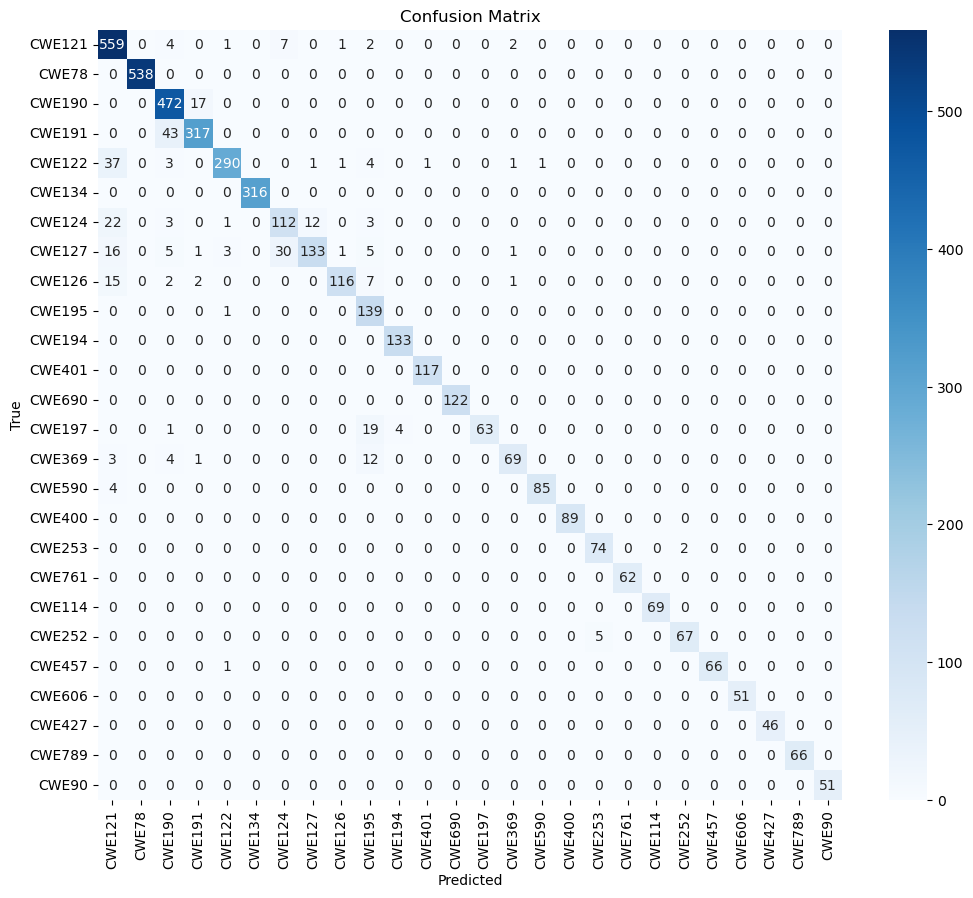

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
# Generate the confusion matrix
cm = confusion_matrix(df_test['label'], preds)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_cwe.values(), yticklabels=label_to_cwe.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()